In [1]:
import os
import sys

import cv2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from skimage import color, measure
from sklearn.neighbors import NearestNeighbors

fontprops = fm.FontProperties(size=34)
from pathlib import Path

sns.set(font_scale=2)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *

In [5]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split("\\")[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [6]:
experiment = datasets[0]

# Read cell mask

In [7]:
markers = []
imgs = []
masks = []

for (dirpath, dirnames, filenames) in os.walk(data_raw / experiment):
    for name in sorted(filenames):
        if "tiff" in name and experiment in name:
            img = cv2.imread(
                os.path.join(dirpath, name),
                flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH),
            )
            imgs.append(img)
            markers.append(name.split("_")[1].split(".")[0])


for (dirpath, dirnames, filenames) in os.walk(data_mask / experiment):
    for name in sorted(filenames):
        if "tiff" in name and experiment in name:
            img = cv2.imread(os.path.join(dirpath, name), 0)
            masks.append(img)

# Read cell mask image
for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
    for name in sorted(filenames):
        if "tiff" in name and experiment in name:
            cell_mask = np.array(Image.open(os.path.join(dirpath, name)))

data = np.stack(imgs, axis=2)

# Spatial proximity plot

In [10]:
DEFAULT_CHANNELS = (1, 2)

RGB_MAP = {
    1: {"rgb": np.array([207, 0, 214]), "range": [0, 255]},
    2: {"rgb": np.array([0, 255, 0]), "range": [0, 255]},
}


def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1, dim2, _ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel - 1] / vmax) / (
            (rgb_map[channel]["range"][1] - rgb_map[channel]["range"][0]) / 255
        ) + rgb_map[channel]["range"][0] / 255
        x = np.where(x > 1.0, 1.0, x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]["rgb"]).reshape(dim1, dim2, 3), dtype=int
        )
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

In [25]:
def plot_interaction(m1, m2, data=data, masks=masks, markers=markers):
    marker2number = dict(zip(markers, [i for i in range(len(markers))]))
    overlay_img = data[:, :, [marker2number[m1], marker2number[m2]]]
    img_rgb = color.rgb2gray(convert_to_rgb(overlay_img))

    # Nearest neighbors distance
    n = 5
    neigh = NearestNeighbors(n_neighbors=n)

    res = cv2.bitwise_and(cell_mask, cell_mask, mask=masks[marker2number[m1]])
    prop = measure.regionprops_table(res, properties=["centroid"])
    X = np.vstack((prop["centroid-0"], prop["centroid-1"])).T
    res = cv2.bitwise_and(cell_mask, cell_mask, mask=masks[marker2number[m2]])
    prop = measure.regionprops_table(res, properties=["centroid"])
    Y = np.vstack((prop["centroid-0"], prop["centroid-1"])).T
    y1, x1 = X.T
    y2, x2 = Y.T

    # fit the NN
    neigh.fit(Y)
    neighbors = neigh.kneighbors(X, return_distance=False)

    # Get the n neirest neighbors position per cell
    n_distance = Y[neighbors]
    fig, ax = plt.subplots(
        2,
        1,
        figsize=(20, 26),
        squeeze=True,
        gridspec_kw={"height_ratios": [4.2, 1], "hspace": 0, "wspace": 0},
    )

    # Plot scatter overlaying image
    ax[0].axis("off")
    ax[0].imshow(img_rgb, cmap=plt.get_cmap("gray"), alpha=0.8, origin="lower")
    ax[0].scatter(
        x2,
        y2,
        color=tuple(RGB_MAP[2]["rgb"] / 255),
        label=m2,
        s=15,
        alpha=0.6,
        edgecolors="none",
    )
    ax[0].scatter(
        x1,
        y1,
        color=tuple(RGB_MAP[1]["rgb"] / 255),
        label=m1,
        s=20,
        alpha=0.6,
        edgecolors="none",
    )
    ax[0].invert_yaxis()
    ax[0].legend(loc=3, markerscale=3.0, fontsize=25)

    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax[0].transData,
        200,
        r"$200  \mu m$",
        "lower right",
        pad=0.1,
        color="white",
        frameon=False,
        size_vertical=3,
        fontproperties=fontprops,
    )

    ax[0].add_artist(scalebar)

    distances = []

    for i, ele in enumerate(X):
        for cell in n_distance[i]:
            y, x = np.array([ele, cell]).T.tolist()
            ax[0].plot(x, y, "b-", color="blue", alpha=0.5)
            distances.append(np.linalg.norm(ele - cell))

    ax[0].set_title("Spatial proximity plot: {}\{}".format(m1, m2), fontsize=30)

    bins = [i * 2 for i in range(30)]
    distance = pd.Series(distances, name="Distance")
    with sns.axes_style("white"):
        sns.distplot(
            distance,
            bins=bins,
            kde=False,
            ax=ax[1],
            hist_kws={"alpha": 1, "color": "r"},
            norm_hist=True,
        )
        sns.despine(offset=10, trim=True, bottom=False)
    plt.xlim(0, 60)
    plt.show()


#     plt.savefig(experiment + '_' + m1+m2+'.png',bbox_inches='tight')

C:\Users\thu71\.conda\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


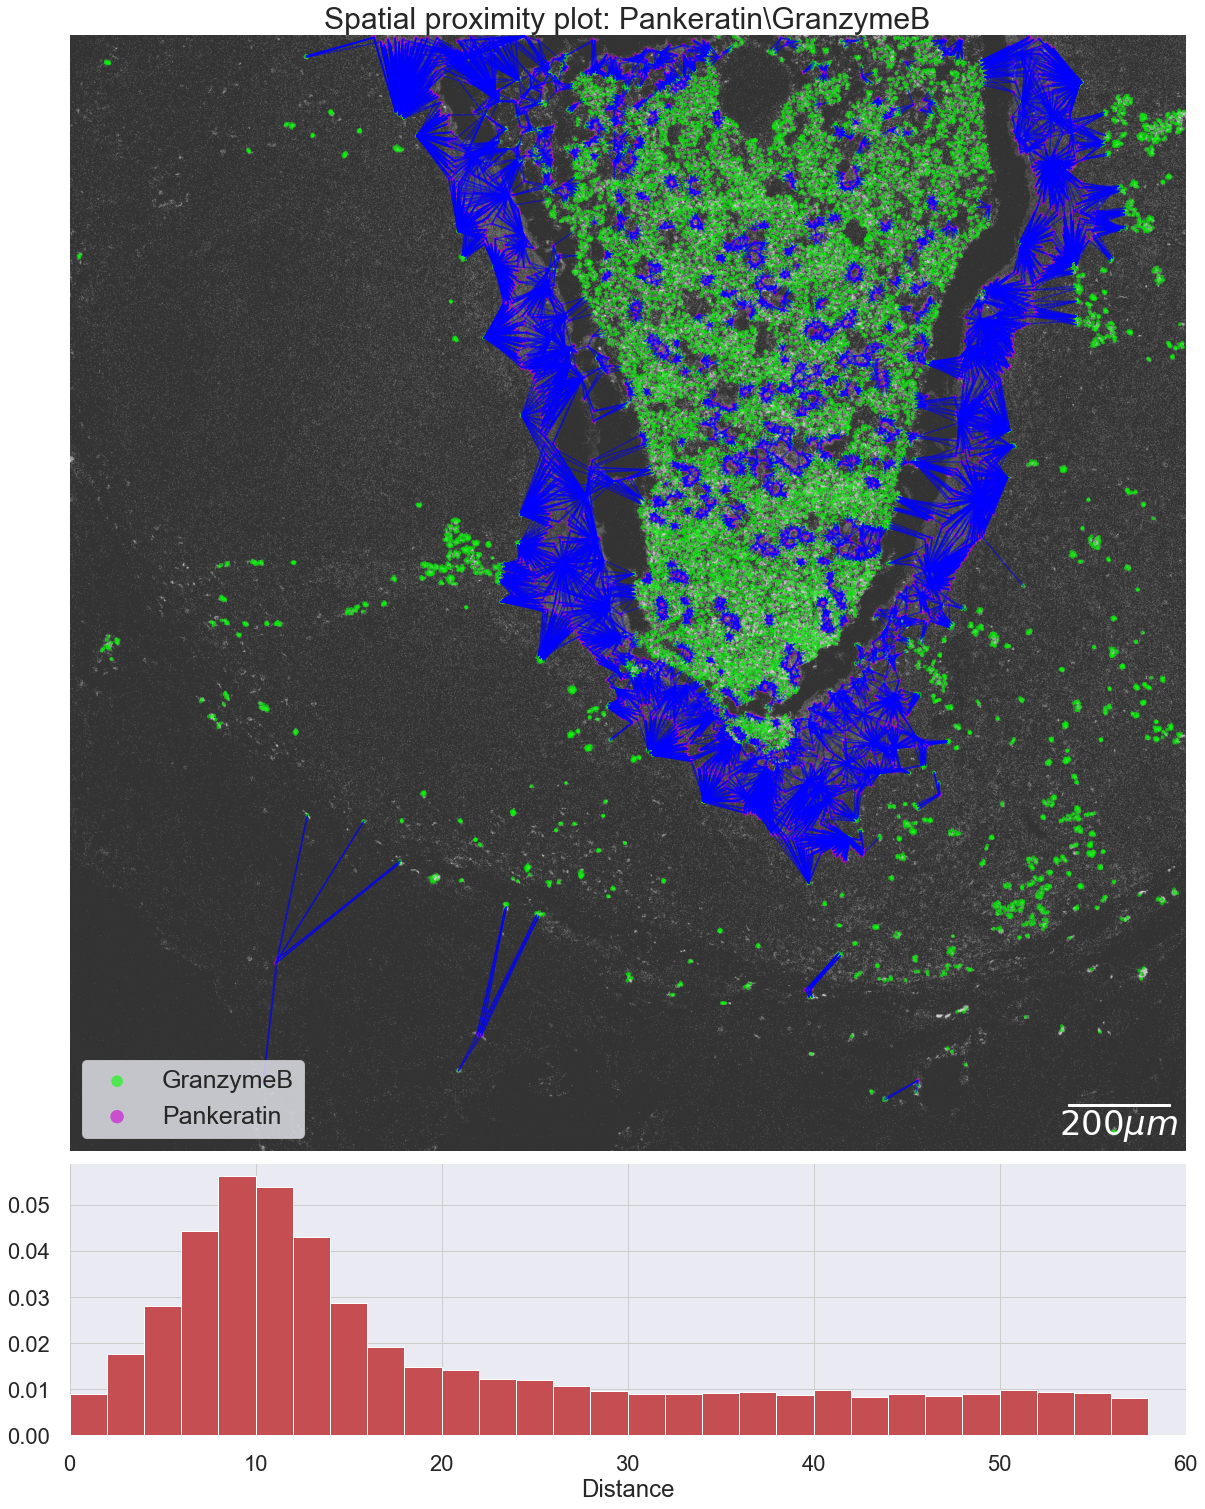

In [26]:
plot_interaction("Pankeratin", "GranzymeB")